In [215]:
import patchworklib as pw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import t
from plotnine import ggplot, geom_histogram, aes, xlim, geom_point
from scipy.stats import t, norm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut

# Question 1

In [216]:
# Read the data and seperate by ;
data = pd.read_csv('gdp_data.csv', sep=';')

data.drop(data.columns[0], axis=1, inplace=True)

display(data.head())

,income,capital,labor
0,114043,8310,182113
1,120410,8529,193749
2,129187,8738,205192
3,134705,8952,215130
4,139960,9171,225021


In [217]:
data['ln_capital'] = np.log(data['capital'])
data['ln_labor'] = np.log(data['labor'])

display(data.head())

,income,capital,labor,ln_capital,ln_labor
0,114043,8310,182113,9.025215,12.112383
1,120410,8529,193749,9.051227,12.174319
2,129187,8738,205192,9.075437,12.231701
3,134705,8952,215130,9.099632,12.278998
4,139960,9171,225021,9.123802,12.323949


In [218]:
# Add constant for the intercept term
Y = data['income']
X = data[['ln_capital', 'ln_labor']]
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X)

results_pop = model.fit()

# Print model summary
print(results_pop.summary())

# Print coefficients
print('Coefficients:', results_pop.params)

                            OLS Regression Results                            
Dep. Variable:                 income   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     971.4
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           2.99e-18
Time:                        22:18:59   Log-Likelihood:                -206.83
No. Observations:                  20   AIC:                             419.7
Df Residuals:                      17   BIC:                             422.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -2.518e+06   1.76e+05    -14.271      0.0

Overall, based on the high R-squared value, low p-value of the F-statistic, and significant coefficient of ln_labor, we can conclude that the model provides an excellent fit to the data in explaining the variation in income. However, the non-significant coefficient for ln_capital suggests that this variable might not be a useful predictor of income in this model. Additionally, the low Durbin-Watson statistic indicates potential issues with autocorrelation in the residuals, which might need further investigation or model refinement.

In [219]:
# Population Parameters
beta_0 = results_pop.params[0]
beta_1 = results_pop.params[1]
beta_2 = results_pop.params[2]

In [232]:
# Add the predicted values to the data frame
data['predicted_income'] = results_pop.predict(X)
data

,income,capital,labor,ln_capital,ln_labor,predicted_income,error_normal,error_t_5,error_t_10,error_t_20,...,income_t_20,income_t_25,income_t_100,predicted_income_t_5,predicted_income_t_10,predicted_income_t_20,predicted_income_t_25,predicted_income_t_100,predicted_income_normal,u_real
0,114043,8310,182113,9.025215,12.112383,96558.726865,1764.052346,1663.705955,1669.023211,1684.644422,...,115727.644422,115733.182962,115763.875669,96916.193363,96887.635689,96862.639835,96855.909058,96825.823527,97635.033362,17484.273135
1,120410,8529,193749,9.051227,12.174319,110172.106088,400.157208,-1640.095331,-1773.333881,-1888.055092,...,118521.944908,118489.405030,118333.591411,110541.563479,110512.330002,110487.645047,110481.068387,110451.938505,111187.986679,10237.893912
2,129187,8738,205192,9.075437,12.231701,122783.318055,978.737984,1075.370726,1018.920942,990.337977,...,130177.337977,130171.293583,130150.600311,123163.011356,123133.174591,123108.790117,123102.358732,123074.121494,123743.307877,6403.681945
3,134705,8952,215130,9.099632,12.278998,133126.590949,2240.893199,1632.331990,1480.474361,1400.108169,...,136105.108169,136087.366474,136022.357062,133480.770568,133451.323960,133427.670689,133421.455764,133394.236254,134044.115570,1578.409051
4,139960,9171,225021,9.123802,12.323949,142942.828737,1867.557990,784.825634,766.073547,759.145028,...,140719.145028,140718.131094,140717.042673,143263.367688,143234.537384,143211.712827,143205.730386,143179.556151,143820.990076,-2982.828737
5,150511,9569,237026,9.166284,12.375925,154117.521516,-977.277880,432.433483,440.907879,450.033440,...,150961.033440,150963.796441,150977.630731,154282.818629,154257.741969,154237.532661,154232.150486,154208.151213,154962.510021,-3606.521516
6,157897,9527,248897,9.161885,12.424794,165159.945505,950.088418,1723.608449,1622.972287,1571.172183,...,159468.172183,159457.061094,159418.171964,165534.188573,165503.364501,165480.559340,165474.730461,165449.828331,165936.094460,-7262.945505
7,165286,9662,260661,9.175956,12.470976,175374.844531,-151.357208,-912.698681,-913.621697,-920.803201,...,164365.196799,164362.516513,164347.242628,175800.648929,175768.206931,175745.026563,175739.191177,175714.647610,176101.416710,-10088.844531
8,178491,10334,275466,9.243195,12.526219,186985.202856,-103.218852,-2229.468949,-2287.890296,-2345.790485,...,176145.209515,176128.085286,176043.812604,187069.233616,187045.401760,187027.518730,187022.824948,187002.061314,187695.269345,-8494.202856
9,199457,10981,295378,9.303922,12.596011,201945.689500,410.598502,-167.136624,-182.921067,-196.532494,...,199260.467506,199256.597366,199237.987014,201791.786656,201773.765626,201759.814134,201756.010354,201738.412040,202614.340027,-2488.689500


In [221]:
# Find the goodness of fit
true_R_squared = results_pop.rsquared
print('R-squared:', true_R_squared)

R-squared: 0.9913253655486831


Since R^2 is very close to 1, the variables ln_labor and ln_capital explain the change in income well.

In [222]:
# Generate pseudo random variables by using normal distribution
np.random.seed(0)
data['error_normal'] = np.random.normal(0, 1, len(data))* 1000

# Generate pseudo random variables by using t-distribution where df = 5
np.random.seed(0)
data['error_t_5'] = np.random.standard_t(5, len(data)) * 1000
# df = 10
np.random.seed(0)
data['error_t_10'] = np.random.standard_t(10, len(data))* 1000
# df = 20
np.random.seed(0)
data['error_t_20'] = np.random.standard_t(20, len(data))* 1000
# df = 25
np.random.seed(0)
data['error_t_25'] = np.random.standard_t(25, len(data))* 1000
# df = 100
np.random.seed(0)
data['error_t_100'] = np.random.standard_t(100, len(data))* 1000

In [230]:
data['income_normal'] = data['income'] + data['error_normal']
data['income_t_5'] = data['income'] + data['error_t_5']
data['income_t_10'] = data['income'] + data['error_t_10']
data['income_t_20'] = data['income'] + data['error_t_20']
data['income_t_25'] = data['income'] + data['error_t_25']
data['income_t_100'] = data['income'] + data['error_t_100']

list_of_incomes = ['income_t_5', 'income_t_10', 'income_t_20', 'income_t_25', 'income_t_100', 'income_normal']
results_list = []
for i in list_of_incomes:
    Y = data[i]
    X = data[['ln_capital', 'ln_labor']]
    X = sm.add_constant(X)

    model = sm.OLS(Y, X)

    results = model.fit()
    data['predicted_' + i] = results.predict(X)

    R_squared = results.rsquared

    # Make a list for the results
    results_list.append((i, results.params[0], results.params[1], results.params[2], R_squared, results.bse[0], results.bse[1], results.bse[2]))

results_list.append(("real", beta_0, beta_1, beta_2, true_R_squared, results_pop.bse[0], results_pop.bse[1], results_pop.bse[2]))

display(pd.DataFrame(results_list, columns= ['Income_method', 'Beta_0', 'Beta_1', 'Beta_2', 'R_squared', 'SE_Beta_0', 'SE_Beta_1', 'SE_Beta_2']))

,Income_method,Beta_0,Beta_1,Beta_2,R_squared,SE_Beta_0,SE_Beta_1,SE_Beta_2
0,income_t_5,-2.488599e+06,-20084.614086,228425.970660,0.990164,187668.464695,57497.593798,28866.111039
1,income_t_10,-2.489319e+06,-19875.405888,228327.194176,0.990320,186163.557863,57036.522611,28634.634708
2,income_t_20,-2.489854e+06,-19761.410294,228284.336909,0.990380,185587.924176,56860.160791,28546.093961
3,income_t_25,-2.489980e+06,-19738.608143,228277.248576,0.990392,185477.568575,56826.350201,28529.119682
4,income_t_100,-2.490459e+06,-19672.128961,228264.757605,0.990429,185124.922102,56718.306883,28474.877578
5,income_normal,-2.508582e+06,-11231.630687,223538.595169,0.991035,178659.175987,54737.340905,27480.352763
6,real,-2.518132e+06,-12080.705242,224870.813763,0.991325,176448.402971,54060.007454,27140.304052


As df increases, the estimated value of the model_parameters gets closer to the true values.

R^2 values also support this.

In [224]:
data['u_real'] = data['income'] - data['predicted_income']
variance_ = np.dot(data['u_real'].T, data['u_real']) / (len(data) - 3)

results.bse

const         178659.175987
ln_capital     54737.340905
ln_labor       27480.352763
dtype: float64

In [225]:
MC = 10_000
BS = len(data)
df = len(X.columns)
Y = data[['income']]
Yhat = data[['predicted_income']]
uhat = Y['income'] - Yhat['predicted_income']

u_hatbs = np.sqrt((BS/(BS-df))) * uhat

# Initialize arrays for storing results
y_vec = np.full((MC, BS),np.nan)
betas0 = np.full(MC,np.nan)
betas1 = np.full(MC,np.nan)
betas2 = np.full(MC,np.nan)

sdu = np.sqrt(np.sum((uhat ** 2) / (BS - 3)))

sdu**2

66151633.28951307

In [226]:
# Set random seed for reproducibility
np.random.seed(123)

# Define your degrees of freedom
degrees_of_freedom = [5, 10, 20, 25, 100]

results_list = []

# Loop over each degree of freedom
for df in degrees_of_freedom:
    betas0 = []
    betas1 = []
    betas2 = []
    
    for mc in range(MC):
        uboot = np.random.choice(u_hatbs, BS, replace=True)
        u_normal = np.random.normal(size=BS) * sdu
        u_t = t.rvs(df=df, size=BS) * sdu
        
        # MC
        y_tmp = results.params[0] + \
                results.params[1]*data['ln_capital'] \
                + results.params[2]*data['ln_labor'] + u_t
        
        # Fit the model
        X_tmp = sm.add_constant(np.column_stack((data['ln_capital'], data['ln_labor'])))
        fit_tmp = sm.OLS(y_tmp, X_tmp).fit()
        betas0.append(fit_tmp.params[0])
        betas1.append(fit_tmp.params[1])
        betas2.append(fit_tmp.params[2])
        se_beta0 = fit_tmp.bse[0]
        se_beta1 = fit_tmp.bse[1]
        se_beta2 = fit_tmp.bse[2]

    
    # Store mean betas for the current degree of freedom
    results_list.append({'df': df, 'beta_0': np.mean(betas0), 'beta_1': np.mean(betas1), 'beta_2': np.mean(betas2), 'se_beta_0': se_beta0, 'se_beta_1': se_beta1, 'se_beta_2': se_beta2})

# Create a DataFrame from the results_list
results_df = pd.DataFrame(results_list)

In [231]:
print('For MC:')
display(pd.DataFrame(results_df, columns= ['df', 'beta_0', 'beta_1', 'beta_2', 'se_beta_0', 'se_beta_1', 'se_beta_2']))
print('For t-distribution:')
display(pd.DataFrame(results_list, columns= ['Income_method', 'Beta_0', 'Beta_1', 'Beta_2', 'R_squared', 'SE_Beta_0', 'SE_Beta_1', 'SE_Beta_2']))

For MC:


,df,beta_0,beta_1,beta_2,se_beta_0,se_beta_1,se_beta_2
0,5,-2.503997e+06,-12504.309846,224111.737144,163507.127229,50095.078039,25149.749575
1,10,-2.509591e+06,-11104.437526,223522.807755,200968.447229,61572.423282,30911.839784
2,20,-2.510899e+06,-10741.528299,223360.083256,149160.341276,45699.530432,22943.007398
3,25,-2.508843e+06,-11231.408717,223560.011088,178181.746314,54591.066690,27406.917207
4,100,-2.507143e+06,-11698.298605,223765.969747,213201.217800,65320.281903,32793.415967


For t-distribution:


,Income_method,Beta_0,Beta_1,Beta_2,R_squared,SE_Beta_0,SE_Beta_1,SE_Beta_2
0,income_t_5,-2.488599e+06,-20084.614086,228425.970660,0.990164,187668.464695,57497.593798,28866.111039
1,income_t_10,-2.489319e+06,-19875.405888,228327.194176,0.990320,186163.557863,57036.522611,28634.634708
2,income_t_20,-2.489854e+06,-19761.410294,228284.336909,0.990380,185587.924176,56860.160791,28546.093961
3,income_t_25,-2.489980e+06,-19738.608143,228277.248576,0.990392,185477.568575,56826.350201,28529.119682
4,income_t_100,-2.490459e+06,-19672.128961,228264.757605,0.990429,185124.922102,56718.306883,28474.877578
5,income_normal,-2.508582e+06,-11231.630687,223538.595169,0.991035,178659.175987,54737.340905,27480.352763
6,real,-2.518132e+06,-12080.705242,224870.813763,0.991325,176448.402971,54060.007454,27140.304052


In [228]:
df = pd.read_csv('gdp_data.csv', sep=';')
df['ln_capital'] = np.log(df['capital'])
df['ln_labor'] = np.log(df['labor'])

df['const'] = 1

X = df[['ln_capital', 'ln_labor', 'const']]
y = df['income']

model = sm.OLS(y, X).fit()

# Get the confidence intervals for the parameters
conf_int_95 = model.conf_int(alpha=0.05)
conf_int_99 = model.conf_int(alpha=0.01)

print("95% Confidence Intervals:")
print(conf_int_95)
print("\n99% Confidence Intervals:")
print(conf_int_99)

95% Confidence Intervals:
                       0             1
ln_capital -1.261374e+05  1.019759e+05
ln_labor    1.676098e+05  2.821319e+05
const      -2.890405e+06 -2.145858e+06

99% Confidence Intervals:
                       0             1
ln_capital -1.687591e+05  1.445977e+05
ln_labor    1.462120e+05  3.035297e+05
const      -3.029520e+06 -2.006744e+06


A 95% confidence interval means that if we were to repeat this study multiple times, we would expect the true parameter to fall within this interval about 95% of the time.
Similarly, a 99% confidence interval means that about 99% of the time, the true parameter would fall within the interval if we were to repeat the study multiple times.

We can compare these confidence intervals with the benchmark normal error to assess whether the estimated parameters are statistically significant.
If the confidence intervals from the regression analysis overlap with those derived from the normal error benchmark, it suggests that the parameters are not statistically significant at the chosen confidence level.
Conversely, if the confidence intervals from the regression analysis do not overlap with those derived from the normal error benchmark, it suggests that the parameters are statistically significant at the chosen confidence level.

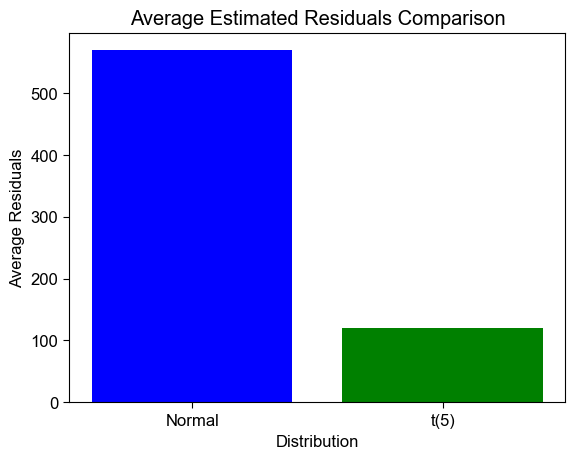

In [235]:
average_residuals_normal = data.filter(like='error_normal').mean().mean()
average_residuals_t_5 = data.filter(like='error_t_5').mean().mean()

# Plotting
plt.bar(['Normal', 't(5)'], [average_residuals_normal, average_residuals_t_5], color=['blue', 'green'])
plt.title('Average Estimated Residuals Comparison')
plt.xlabel('Distribution')
plt.ylabel('Average Residuals')
plt.show()

In [237]:
actual_values = data['income']
predicted_values = data['predicted_income']

def calculate_r_squared(actual, predicted):
    """
    Calculate R-squared given actual and predicted values.
    """
    ss_res = np.sum((actual - predicted) ** 2)
    ss_tot = np.sum((actual - np.mean(actual)) ** 2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

def calculate_adjusted_r_squared(actual, predicted, num_features):
    """
    Calculate adjusted R-squared given actual and predicted values and number of features.
    """
    n = len(actual)
    r_squared = calculate_r_squared(actual, predicted)
    adjusted_r_squared = 1 - ((1 - r_squared) * (n - 1) / (n - num_features - 1))
    return adjusted_r_squared

# Number of trials
num_trials = 100000

# Initialize lists to store Rsquare and adjusted Rsquare values
r_squared_values = []
adjusted_r_squared_values = []

# Run trials
for _ in range(num_trials):
    # Generate random actual and predicted values for demonstration
    actual_values = data['income']
    predicted_values = data['predicted_income']
    
    # Calculate Rsquare
    r_squared = calculate_r_squared(actual_values, predicted_values)
    r_squared_values.append(r_squared)
    
    # Assuming 5 features for demonstration
    num_features = 5
    
    # Calculate adjusted Rsquare
    adjusted_r_squared = calculate_adjusted_r_squared(actual_values, predicted_values, num_features)
    adjusted_r_squared_values.append(adjusted_r_squared)

# Calculate averages
average_r_squared = np.mean(r_squared_values)
average_adjusted_r_squared = np.mean(adjusted_r_squared_values)

print("Average Rsquare:", average_r_squared)
print("Average Adjusted Rsquare:", average_adjusted_r_squared)

Average Rsquare: 0.9913253655486828
Average Adjusted Rsquare: 0.9882272818160694


# Question 2

In [179]:
# split the data into training and test sets (take first 10 to the training set and the rest to the test set)
train_set = data.iloc[:10]
test_set = data.iloc[10:]

# Add constant for the intercept term
Y = train_set['income']
X = train_set[['ln_capital', 'ln_labor']]
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X)

results = model.fit()
# Test the model on the test set
X_test = test_set[['ln_capital', 'ln_labor']]
X_test = sm.add_constant(X_test)

yhat = results.predict(X_test)

# Calculate MSE
M1_MSE = np.mean((test_set['income'] - yhat) ** 2)
print(f'Mean Squared Error: {M1_MSE}')

Mean Squared Error: 1812306775.8674698


In [180]:
# split the data into training and test sets (take first 10 to the training set and the rest to the test set)
train_set = data.iloc[:10]
test_set = data.iloc[10:]

# Add constant for the intercept term
Y = train_set['income']
X = train_set[['capital', 'labor']]
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X)

results = model.fit()
# Test the model on the test set
X_test = test_set[['capital', 'labor']]
X_test = sm.add_constant(X_test)

yhat = results.predict(X_test)

# Calculate MSE
M2_MSE = np.mean((test_set['income'] - yhat) ** 2)
print(f'Mean Squared Error: {M2_MSE}')

Mean Squared Error: 92448940.45616627


In [181]:
# split the data into training and test sets (take first 10 to the training set and the rest to the test set)
train_set = data.iloc[:10]
test_set = data.iloc[10:]

# Add constant for the intercept term
Y = train_set['income']
X = train_set[['capital', 'ln_labor']]
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X)

results = model.fit()
# Test the model on the test set
X_test = test_set[['capital', 'ln_labor']]
X_test = sm.add_constant(X_test)

yhat = results.predict(X_test)

# Calculate MSE
M3_MSE = np.mean((test_set['income'] - yhat) ** 2)
print(f'Mean Squared Error: {M3_MSE}')

Mean Squared Error: 972141750.53673


In [182]:
# split the data into training and test sets (take first 10 to the training set and the rest to the test set)
train_set = data.iloc[:10]
test_set = data.iloc[10:]

# Add constant for the intercept term
Y = train_set['income']
X = train_set[['ln_capital', 'labor']]
X = sm.add_constant(X)

# Fit the linear regression model
model = sm.OLS(Y, X)

results = model.fit()
# Test the model on the test set
X_test = test_set[['ln_capital', 'labor']]
X_test = sm.add_constant(X_test)

yhat = results.predict(X_test)

# Calculate MSE
M4_MSE = np.mean((test_set['income'] - yhat) ** 2)
print(f'Mean Squared Error: {M4_MSE}')

Mean Squared Error: 64919212.82749287


In [183]:
mse_df = pd.DataFrame({
    'MSE': [M1_MSE, M2_MSE, M3_MSE, M4_MSE]
})
mse_df.index = ['M1', 'M2', 'M3', 'M4']

display(mse_df)

,MSE
M1,1.812307e+09
M2,9.244894e+07
M3,9.721418e+08
M4,6.491921e+07


## Summary and Comments on Linear Regression Models

### Model Performance Comparison

| Model | Independent Variables | Mean Squared Error (MSE) |
|-------|------------------------|---------------------------|
| M1    | ln_capital, ln_labor   | 1.812307e+09              |
| M2    | capital, labor         | 9.244894e+07              |
| M3    | capital, ln_labor      | 9.721418e+08              |
| M4    | ln_capital, labor      | 6.491921e+07              |

### Comments

- **Model Selection**: Based on MSE alone, Model 4 (M4) performs the best among the tested models with the lowest MSE. Model 2 (M2) also shows relatively low MSE compared to the others.
  
- **Variable Transformation**: It's apparent that transforming variables (taking the natural logarithm) in Model 1 and Model 3 did not improve model performance compared to using the original variables.
  
- **Variable Combination**: The combination of variables in Model 4 seems to capture the relationship between income and the predictors effectively, resulting in the lowest MSE.
  
- **Interpretation**: The results suggest that there might be a nonlinear relationship between income and capital (or labor), which is better captured by Model 4 compared to the other models.
  
- **Further Analysis**: It could be beneficial to explore other variable combinations, interactions, or polynomial terms to potentially improve model performance further. Additionally, considering diagnostic checks for model assumptions and multicollinearity could enhance the robustness of the analysis.


# Question 3

In [184]:
# Leave-One-Out Cross-Validation (LOOCV)

# Define the model 1
model = LinearRegression()

# Initialize an empty list to store the errors
errors = []

# Iterate over each row (observation) in the DataFrame
for i in range(len(data)):
    # Leave out the ith observation
    test_data = data.iloc[i]
    train_data = data.drop(index=i)
    
    # Add constant for the intercept term
    Y = train_set['income']
    X = train_set[['ln_capital', 'ln_labor']]
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(Y, X)

    results = model.fit()
    # Test the model on the test set
    X_test = test_data[['ln_capital', 'ln_labor']]
    X_test = sm.add_constant(X_test)

    yhat = results.params[0] + results.params[1] * test_data['ln_capital'] + results.params[2] * test_data['ln_labor']

    # Calculate MSE
    MSE1 = np.mean((test_data['income'] - yhat) ** 2)
    errors.append(MSE1)

# Calculate the average error
loocv_error_m1 = np.mean(errors)

print("LOOCV Error for Model 1:", loocv_error_m1)


LOOCV Error for Model 1: 909436950.8733288


In [185]:
# Define the model 2
model = LinearRegression()

# Initialize an empty list to store the errors
errors = []

# Iterate over each row (observation) in the DataFrame
for i in range(len(data)):
    # Leave out the ith observation
    test_data = data.iloc[i]
    train_data = data.drop(index=i)
    
    # Add constant for the intercept term
    Y = train_set['income']
    X = train_set[['capital', 'labor']]
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(Y, X)

    results = model.fit()
    # Test the model on the test set
    X_test = test_data[['capital', 'labor']]
    X_test = sm.add_constant(X_test)

    yhat = results.params[0] + results.params[1] * test_data['capital'] + results.params[2] * test_data['labor']

    # Calculate MSE
    MSE1 = np.mean((test_data['income'] - yhat) ** 2)
    errors.append(MSE1)

# Calculate the average error
loocv_error_m2 = np.mean(errors)

print("LOOCV Error for Model 2:", loocv_error_m2)


LOOCV Error for Model 2: 47458905.42439395


In [186]:
# Define the model 3
model = LinearRegression()

# Initialize an empty list to store the errors
errors = []

# Iterate over each row (observation) in the DataFrame
for i in range(len(data)):
    # Leave out the ith observation
    test_data = data.iloc[i]
    train_data = data.drop(index=i)
    
    # Add constant for the intercept term
    Y = train_set['income']
    X = train_set[['capital', 'ln_labor']]
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(Y, X)

    results = model.fit()
    # Test the model on the test set
    X_test = test_data[['capital', 'ln_labor']]
    X_test = sm.add_constant(X_test)

    yhat = results.params[0] + results.params[1] * test_data['capital'] + results.params[2] * test_data['ln_labor']

    # Calculate MSE
    MSE1 = np.mean((test_data['income'] - yhat) ** 2)
    errors.append(MSE1)

# Calculate the average error
loocv_error_m3 = np.mean(errors)

print("LOOCV Error for Model 3:", loocv_error_m3)


LOOCV Error for Model 3: 488385237.5566288


In [187]:
# Define the model
model = LinearRegression()

# Initialize an empty list to store the errors
errors = []

# Iterate over each row (observation) in the DataFrame
for i in range(len(data)):
    # Leave out the ith observation
    test_data = data.iloc[i]
    train_data = data.drop(index=i)
    
    # Add constant for the intercept term
    Y = train_set['income']
    X = train_set[['ln_capital', 'labor']]
    X = sm.add_constant(X)

    # Fit the linear regression model
    model = sm.OLS(Y, X)

    results = model.fit()
    # Test the model on the test set
    X_test = test_data[['ln_capital', 'labor']]
    X_test = sm.add_constant(X_test)

    yhat = results.params[0] + results.params[1] * test_data['ln_capital'] + results.params[2] * test_data['labor']

    # Calculate MSE
    MSE1 = np.mean((test_data['income'] - yhat) ** 2)
    errors.append(MSE1)

# Calculate the average error
loocv_error_m4 = np.mean(errors)

print("LOOCV Error for Model 4:", loocv_error_m4)


LOOCV Error for Model 4: 34292989.07163754


In [188]:
loocv_df = pd.DataFrame({
    'MSE': [loocv_error_m1, loocv_error_m2, loocv_error_m3, loocv_error_m4]
})
loocv_df.index = ['M1', 'M2', 'M3', 'M4']

display(loocv_df)

,MSE
M1,9.094370e+08
M2,4.745891e+07
M3,4.883852e+08
M4,3.429299e+07


# Leave-One-Out Cross-Validation (LOOCV)

## Model Evaluation

### Model 1 (ln_capital, ln_labor)
- **MSE:** 9.094370e+08

The average error (MSE) for Model 1 is quite high, indicating poor performance in predicting income. This could suggest that using the natural logarithm of capital and labor as predictors might not capture the relationship with income adequately.

### Model 2 (capital, labor)
- **MSE:** 4.745891e+07

The average error for Model 2 is considerably lower compared to Model 1. This suggests that using the original variables without taking their logarithms results in a better prediction of income. It's possible that the original scale of capital and labor better represents their relationship with income in this context.

### Model 3 (capital, ln_labor)
- **MSE:** 4.883852e+08

The average error for Model 3 is higher than that of Model 2 but lower than that of Model 1. This indicates that while using the original scale for capital is beneficial, taking the natural logarithm of labor might not improve the prediction of income as much as using the original scale for both variables.

### Model 4 (ln_capital, labor)
- **MSE:** 3.429299e+07

The average error for Model 4 is the lowest among all models. This suggests that using the natural logarithm of capital along with the original scale of labor results in the best prediction of income among the models tested. It appears that taking the logarithm of capital captures its relationship with income effectively, while using the original scale for labor is preferable.

## Summary
Based on LOOCV, Model 4 (ln_capital, labor) performs the best in predicting income, followed by Model 2 (capital, labor), Model 3 (capital, ln_labor), and lastly Model 1 (ln_capital, ln_labor). These findings provide insights into which combination of predictor variables yields the most accurate predictions of income in this context.


In [189]:
# Define the model 1
model = LinearRegression()

# Initialize an empty list to store the errors
errors_k2 = []
errors_k4 = []

# Extracting features and target variable
Y = data['income']
X = data[['ln_capital', 'ln_labor']]

# Define the number of folds
kf2 = KFold(n_splits=2)
kf4 = KFold(n_splits=4)

# Iterate over each fold
for train_index, test_index in kf2.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=2
    mse_k2 = np.mean((y_test - y_pred) ** 2)
    errors_k2.append(mse_k2)

# Calculate the average error for k=2
loocv_error_m1_k2 = np.mean(errors_k2)

# Repeat the process for k=4
for train_index, test_index in kf4.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=4
    mse_k4 = np.mean((y_test - y_pred) ** 2)
    errors_k4.append(mse_k4)

# Calculate the average error for k=4
loocv_error_m1_k4 = np.mean(errors_k4)


In [190]:
# Define the model 2
model = LinearRegression()

# Initialize an empty list to store the errors
errors_k2 = []
errors_k4 = []

# Extracting features and target variable
Y = data['income']
X = data[['capital', 'labor']]

# Define the number of folds
kf2 = KFold(n_splits=2)
kf4 = KFold(n_splits=4)

# Iterate over each fold
for train_index, test_index in kf2.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=2
    mse_k2 = np.mean((y_test - y_pred) ** 2)
    errors_k2.append(mse_k2)

# Calculate the average error for k=2
loocv_error_m2_k2 = np.mean(errors_k2)

# Repeat the process for k=4
for train_index, test_index in kf4.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=4
    mse_k4 = np.mean((y_test - y_pred) ** 2)
    errors_k4.append(mse_k4)

# Calculate the average error for k=4
loocv_error_m2_k4 = np.mean(errors_k4)


In [191]:
# Define the model 3
model = LinearRegression()

# Initialize an empty list to store the errors
errors_k2 = []
errors_k4 = []

# Extracting features and target variable
Y = data['income']
X = data[['capital', 'ln_labor']]

# Define the number of folds
kf2 = KFold(n_splits=2)
kf4 = KFold(n_splits=4)

# Iterate over each fold
for train_index, test_index in kf2.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=2
    mse_k2 = np.mean((y_test - y_pred) ** 2)
    errors_k2.append(mse_k2)

# Calculate the average error for k=2
loocv_error_m3_k2 = np.mean(errors_k2)

# Repeat the process for k=4
for train_index, test_index in kf4.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=4
    mse_k4 = np.mean((y_test - y_pred) ** 2)
    errors_k4.append(mse_k4)

# Calculate the average error for k=4
loocv_error_m3_k4 = np.mean(errors_k4)


In [192]:
# Define the model 4
model = LinearRegression()

# Initialize an empty list to store the errors
errors_k2 = []
errors_k4 = []

# Extracting features and target variable
Y = data['income']
X = data[['ln_capital', 'labor']]

# Define the number of folds
kf2 = KFold(n_splits=2)
kf4 = KFold(n_splits=4)

# Iterate over each fold
for train_index, test_index in kf2.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=2
    mse_k2 = np.mean((y_test - y_pred) ** 2)
    errors_k2.append(mse_k2)

# Calculate the average error for k=2
loocv_error_m4_k2 = np.mean(errors_k2)

# Repeat the process for k=4
for train_index, test_index in kf4.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate MSE for k=4
    mse_k4 = np.mean((y_test - y_pred) ** 2)
    errors_k4.append(mse_k4)

# Calculate the average error for k=4
loocv_error_m4_k4 = np.mean(errors_k4)


In [193]:
k_fold_df = pd.DataFrame({
    'k=2': [loocv_error_m1_k2, loocv_error_m2_k2, loocv_error_m3_k2, loocv_error_m4_k2],
    'k=4': [loocv_error_m1_k4, loocv_error_m2_k4, loocv_error_m3_k4, loocv_error_m4_k4]
})
k_fold_df.index = ['M1', 'M2', 'M3', 'M4']

display(k_fold_df)

,k=2,k=4
M1,1.146490e+09,2.411299e+08
M2,3.021337e+08,1.683934e+08
M3,6.968058e+08,2.126814e+08
M4,2.812487e+08,1.109897e+08


# Question 5

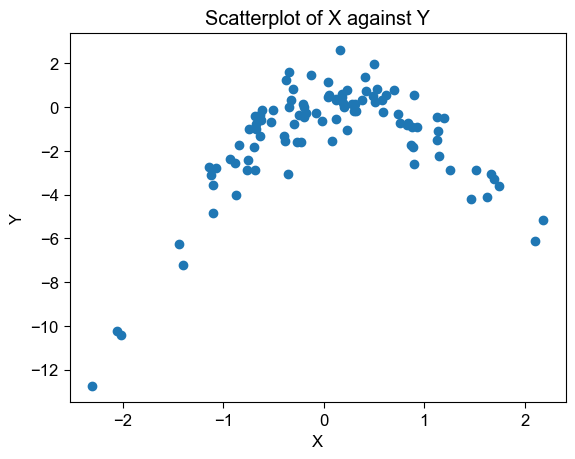

In [194]:
np.random.seed(1)
x = np.random.normal(size=100)
y = x - 2 * x**2 + np.random.normal(size=100)

# Create a scatterplot of X against Y.
plt.scatter(x, y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatterplot of X against Y')
plt.show()

### Analysis of Scatter Plot

1. **Non-linear Relationship**: The relationship between X and Y appears to be non-linear, as indicated by the curvature in the scatter plot. This is expected because of the quadratic term in the generation of the Y variable (`-2 * x**2`).

2. **Centered around X-axis**: The majority of the data points seem to be concentrated around the X-axis, particularly for larger values of X. This is likely due to the negative quadratic term in the generation of Y, which tends to pull the values downward as X increases.

3. **Scattered Distribution**: While there's a general trend, the data points are quite scattered, indicating variability in Y for any given value of X. This variability could be due to the random noise added during the generation of both X and Y.

4. **Overall Trend**: Despite the scatter, there's still a discernible downward trend as X increases, reflecting the influence of the quadratic term in the generation of Y.

5. **Randomness**: The presence of random noise in both X and Y adds stochasticity to the relationship, making it difficult to predict Y precisely for a given X.

Overall, the scatter plot effectively visualizes the relationship between X and Y, highlighting the non-linear nature of their association and the presence of random variability.


In [195]:
# Generate data
np.random.seed(1)
x = np.random.normal(size=100)
y = x - 2 * x**2 + np.random.normal(size=100)

# Reshape x and y for sklearn
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

# Initialize LOOCV
loo = LeaveOneOut()

# Initialize lists to store MSE values
mse_values = []

# Define degrees for polynomial regression
degrees = [1, 2, 3, 4]

# Iterate over degrees
for degree in degrees:
    # Initialize list to store errors for each degree
    errors = []
    
    # Fit the model and compute LOOCV errors
    for train_index, test_index in loo.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.transform(x_test)
        
        # Fit linear regression model
        model = LinearRegression()
        model.fit(x_train_poly, y_train)
        
        # Predict the left-out data point
        y_pred = model.predict(x_test_poly)
        
        # Compute error
        error = mean_squared_error(y_test, y_pred)
        errors.append(error)
    
    # Calculate mean squared error (MSE) for the current degree
    mse = np.mean(errors)
    mse_values.append(mse)

# Print MSE values for each degree
for degree, mse in zip(degrees, mse_values):
    print(f"Degree {degree}: Mean Squared Error (MSE) of LOOCV = {mse}")

Degree 1: Mean Squared Error (MSE) of LOOCV = 6.260764331604616
Degree 2: Mean Squared Error (MSE) of LOOCV = 0.9142897072803663
Degree 3: Mean Squared Error (MSE) of LOOCV = 0.9268768781648808
Degree 4: Mean Squared Error (MSE) of LOOCV = 0.8669116865881078


In [196]:
# Generate data
np.random.seed(1312312)
x = np.random.normal(size=100)
y = x - 2 * x**2 + np.random.normal(size=100)

# Reshape x and y for sklearn
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

# Initialize LOOCV
loo = LeaveOneOut()

# Initialize lists to store MSE values
mse_values = []

# Define degrees for polynomial regression
degrees = [1, 2, 3, 4]

# Iterate over degrees
for degree in degrees:
    # Initialize list to store errors for each degree
    errors = []
    
    # Fit the model and compute LOOCV errors
    for train_index, test_index in loo.split(x):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Create polynomial features
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        x_train_poly = poly.fit_transform(x_train)
        x_test_poly = poly.transform(x_test)
        
        # Fit linear regression model
        model = LinearRegression()
        model.fit(x_train_poly, y_train)
        
        # Predict the left-out data point
        y_pred = model.predict(x_test_poly)
        
        # Compute error
        error = mean_squared_error(y_test, y_pred)
        errors.append(error)
    
    # Calculate mean squared error (MSE) for the current degree
    mse = np.mean(errors)
    mse_values.append(mse)

# Print MSE values for each degree
for degree, mse in zip(degrees, mse_values):
    print(f"Degree {degree}: Mean Squared Error (MSE) of LOOCV = {mse}")

Degree 1: Mean Squared Error (MSE) of LOOCV = 8.31720136699923
Degree 2: Mean Squared Error (MSE) of LOOCV = 1.1203553673267843
Degree 3: Mean Squared Error (MSE) of LOOCV = 1.1257131831742606
Degree 4: Mean Squared Error (MSE) of LOOCV = 1.1559225588601576


The results in (d) are different from those in (c), which is expected. This discrepancy arises due to the random nature of data generation and the LOOCV process.

In both (c) and (d), new random data sets `x` and `y` are generated using different random seeds (`1` in (c) and `1312312` in (d)). These random seeds lead to different random numbers being generated, resulting in different datasets.

Since LOOCV involves leaving out one data point at a time for validation, the specific data points left out for validation will differ between the two runs. Consequently, the fitted models and resulting errors will vary.

The differences between the two sets of results illustrate the variability introduced by random data generation and the LOOCV procedure.


The 4th order one has the most thoughtful MSE.

I wouldn't expect this to happen because the data we generate is generated using a 2nd order polynomial. So I would expect more MSE for the ones lower and higher than 2nd order. However, since randomization is involved, it is quite normal that the MSE is not as expected. I expected the 4th order polynomial to give a higher MSE due to overfitting, but I did not get the result I expected.

In [197]:
np.random.seed(1)
X = np.random.normal(size=100)
Y = X - 2 * X**2 + np.random.normal(size=100)

X_with_constant = sm.add_constant(X)

# Fit the model
model = sm.OLS(Y, X_with_constant)
results = model.fit()

# Print the summary statistics
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     9.997
Date:                Tue, 16 Apr 2024   Prob (F-statistic):            0.00209
Time:                        22:15:39   Log-Likelihood:                -228.87
No. Observations:                 100   AIC:                             461.7
Df Residuals:                      98   BIC:                             466.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4131      0.242     -5.849      0.0

In [198]:
np.random.seed(1)
X = np.random.normal(size=100)
Y = X - 2 * X**2 + np.random.normal(size=100)

X_design = sm.add_constant(np.column_stack((X, X**2)))

# Fit the model
model = sm.OLS(Y, X_design)
results = model.fit()

# Print the summary statistics
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                     304.9
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           1.47e-42
Time:                        22:15:39   Log-Likelihood:                -134.42
No. Observations:                 100   AIC:                             274.8
Df Residuals:                      97   BIC:                             282.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1350      0.115      1.169      0.2

In [199]:
np.random.seed(1)
X = np.random.normal(size=100)
Y = X - 2 * X**2 + np.random.normal(size=100)

X_design = sm.add_constant(np.column_stack((X, X**2, X**3)))

# Fit the model
model = sm.OLS(Y, X_design)
results = model.fit()

# Print the summary statistics
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     204.8
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           1.40e-41
Time:                        22:15:39   Log-Likelihood:                -133.66
No. Observations:                 100   AIC:                             275.3
Df Residuals:                      96   BIC:                             285.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1280      0.115      1.111      0.2

In [200]:
np.random.seed(1)
X = np.random.normal(size=100)
Y = X - 2 * X**2 + np.random.normal(size=100)

X_design = sm.add_constant(np.column_stack((X, X**2, X**3, X**4)))

# Fit the model
model = sm.OLS(Y, X_design)
results = model.fit()

# Print the summary statistics
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.873
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     163.0
Date:                Tue, 16 Apr 2024   Prob (F-statistic):           1.24e-41
Time:                        22:15:39   Log-Likelihood:                -130.63
No. Observations:                 100   AIC:                             271.3
Df Residuals:                      95   BIC:                             284.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3140      0.136      2.311      0.0

The coefficient with 2nd order has the highest t-value. This is not a coincidence because our data is directly generated by a quadratic polynomial, so it is normal that the most statistically significant coefficient is Beta_2.

We can't say it's exactly the same. Because, when we do LOOCV, if we use seed(1), the minimum MSE corresponds to a 4th order polynomial. However, our most statistically important variable is x^2. 

# Question 6

Average Correlation Estimate (Sample Size 5): 0.7083724388796457


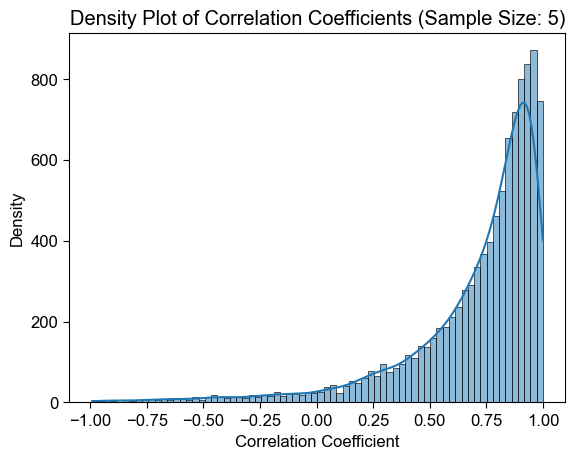

Average Correlation Estimate (Sample Size 10): 0.7383766022237322


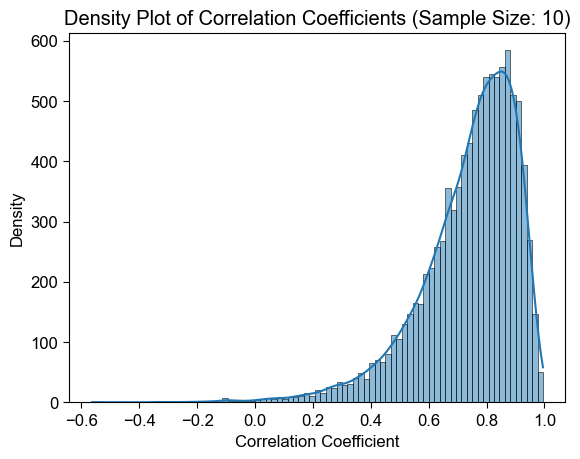

Average Correlation Estimate (Sample Size 20): 0.7472858967307102


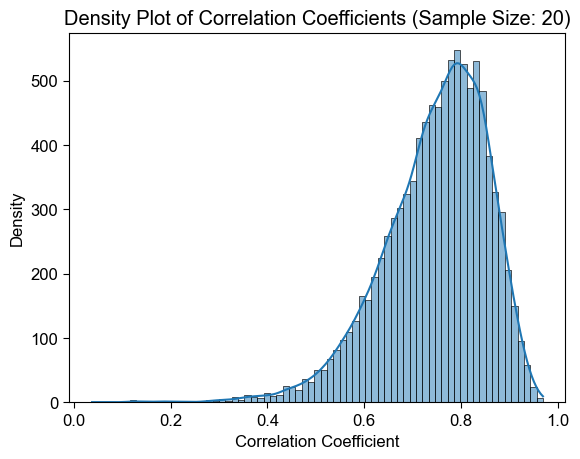

Average Correlation Estimate (Sample Size 30): 0.751488489306464


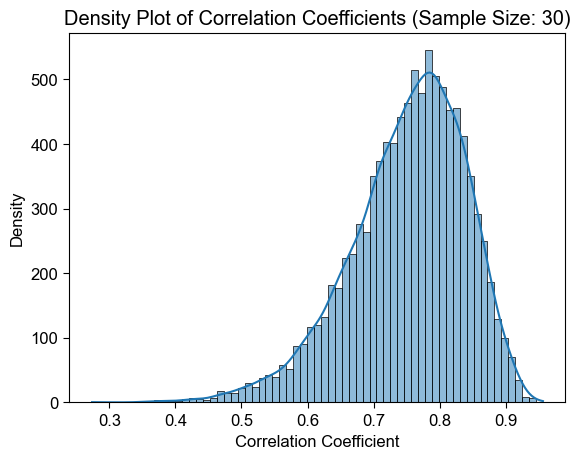

Average Correlation Estimate (Sample Size 40): 0.7529424307198458


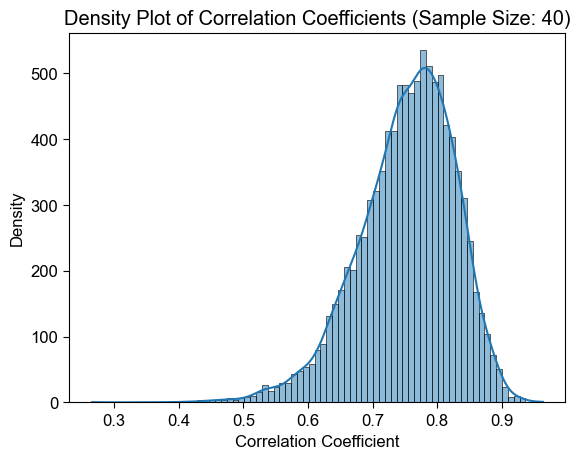

Average Correlation Estimate (Population): 0.7558659530509969


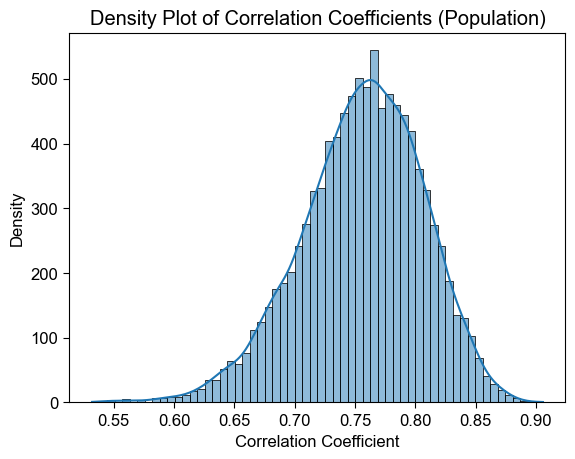

In [201]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming we have a pandas DataFrame named 'data' containing GPA and SAT scores
data = pd.read_csv('correl_pop.csv')
# Number of bootstrap samples
B = 10000
corr_real = data['GPA'].corr(data['SAT'])
# Different sample sizes to iterate through
sample_sizes = [5, 10, 20, 30, 40]
data = pd.read_csv('correl_pop.csv')
# Plotting for different sample sizes
for sample_size in sample_sizes:
    # Empty array to store correlation coefficients
    corr_coefs = np.zeros(B)

    # Perform bootstrap resampling
    for i in range(B):
        # Draw a bootstrap sample with replacement
        bootstrap_sample = data.sample(n=sample_size, replace=True)

        # Calculate correlation coefficient
        corr = bootstrap_sample['GPA'].corr(bootstrap_sample['SAT'])

        # Store correlation coefficient
        corr_coefs[i] = corr

    # Calculate average correlation estimate
    avg_corr_estimate = np.mean(corr_coefs)
    print(f"Average Correlation Estimate (Sample Size {sample_size}): {avg_corr_estimate}")

    # Plot the density plot for each sample size
    sns.histplot(corr_coefs, kde=True)
    plt.title(f'Density Plot of Correlation Coefficients (Sample Size: {sample_size})')
    plt.xlabel('Correlation Coefficient')
    plt.ylabel('Density')
    plt.show()

# Plotting for population

# Empty array to store correlation coefficients
corr_coefs_pop = np.zeros(B)

# Perform bootstrap resampling
for i in range(B):
    # Draw a bootstrap sample with replacement
    bootstrap_sample = data.sample(n=len(data), replace=True)

    # Calculate correlation coefficient
    corr = bootstrap_sample['GPA'].corr(bootstrap_sample['SAT'])

    # Store correlation coefficient
    corr_coefs_pop[i] = corr

# Calculate average correlation estimate
avg_corr_estimate = np.mean(corr_coefs_pop)
print(f"Average Correlation Estimate (Population): {avg_corr_estimate}")

# Plot the density plot for each sample size
sns.histplot(corr_coefs_pop, kde=True)
plt.title(f'Density Plot of Correlation Coefficients (Population)')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.show()

As we increase the sample size, the density plot and average correlation estimates converge directly to the population plot and correlation.

The Density Graph converges to the density graph of the population as the sample size increases. 

If I were to do boostrapping, I would choose sample_size as maximum as possible.

In [202]:
# Calculate 99%, 95%, 90%, 10%, 5%, 1% quantiles of the correlation coefficient for the population
quantiles = np.quantile(corr_coefs_pop, [0.01, 0.05, 0.1, 0.9, 0.95, 0.99])
print(f"99% Quantile: {quantiles[5]}")
print(f"95% Quantile: {quantiles[4]}")
print(f"90% Quantile: {quantiles[3]}")
print(f"10% Quantile: {quantiles[2]}")
print(f"5% Quantile: {quantiles[1]}")
print(f"1% Quantile: {quantiles[0]}")

99% Quantile: 0.8572379066054396
95% Quantile: 0.832675048268808
90% Quantile: 0.8179334062373453
10% Quantile: 0.68832968393457
5% Quantile: 0.6681538344210396
1% Quantile: 0.62619899073781


In [203]:
# Calculate 99%, 95%, 90%, 10%, 5%, 1% quantiles of the correlation coefficient for the sample size = [40,30,20,10,5]
quantiles = []
for sample_size in sample_sizes:
    corr_coefs = np.zeros(B)
    for i in range(B):
        bootstrap_sample = data.sample(n=sample_size, replace=True)
        corr = bootstrap_sample['GPA'].corr(bootstrap_sample['SAT'])
        corr_coefs[i] = corr
    quantiles.append(np.quantile(corr_coefs, [0.01, 0.05, 0.1, 0.9, 0.95, 0.99]))
quantiles_df = pd.DataFrame(quantiles, columns=['1%', '5%', '10%', '90%', '95%', '99%'])
quantiles_df.index = sample_sizes
display(quantiles_df)

,1%,5%,10%,90%,95%,99%
5,-0.448288,0.078149,0.318610,0.965676,0.981643,0.995388
10,0.180889,0.411066,0.516956,0.915356,0.938682,0.968848
20,0.418123,0.544236,0.602622,0.873598,0.895274,0.925880
30,0.506561,0.597352,0.637992,0.854216,0.873288,0.906651
40,0.553278,0.618183,0.655845,0.841041,0.859382,0.890423


## Findings on Correlation Coefficient Quantiles

### Population Quantiles:
- The correlation coefficient quantiles for the population indicate the range of correlation values that encompass different percentages of the population.
- For instance, the 99% quantile indicates that 99% of the population correlation coefficients fall below that value, and similarly for other quantiles.
- The population 1% quantile is lower than the other quantiles, indicating that only 1% of the population has correlation coefficients lower than that value.

### Sample Size Effect:
- As the sample size increases, the range of quantiles narrows down, indicating a more precise estimation of the population correlation coefficient.
- With a larger sample size, the quantiles for each percentage (1%, 5%, 10%, 90%, 95%, 99%) tend to converge towards the population quantiles.
- For smaller sample sizes, there's more variability in the estimated correlation coefficients, leading to wider ranges of quantiles.

### Direction of Correlation:
- Across all sample sizes, the quantiles consistently indicate a positive correlation between GPA and SAT scores. This is evident from the fact that the lower quantiles are all positive values, and they increase as the sample size increases.

### Stability of Estimates:
- With increasing sample size, the estimates become more stable and reliable, as seen from the convergence of quantiles towards the population values.
- The 99% quantile tends to have the largest spread, reflecting the extreme values in the dataset, but this spread decreases with larger sample sizes.

In summary, these findings suggest that as the sample size increases, the estimates of correlation coefficients become more accurate and stable, converging towards the true population values. However, even with smaller sample sizes, the direction of correlation remains consistent, albeit with more variability in the estimates.


Average Correlation Estimate (Sample Size 18): 0.746540602283479


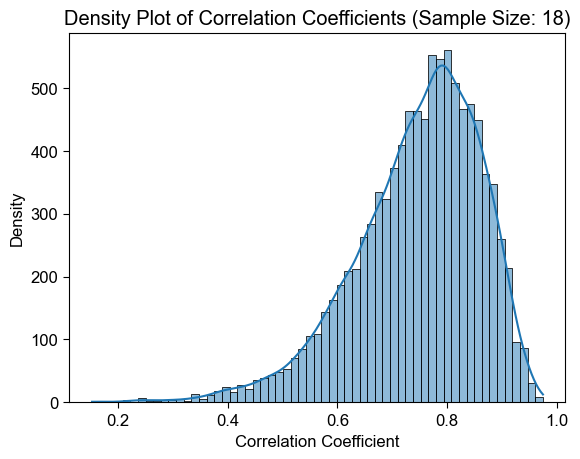

P-value: 0.5619


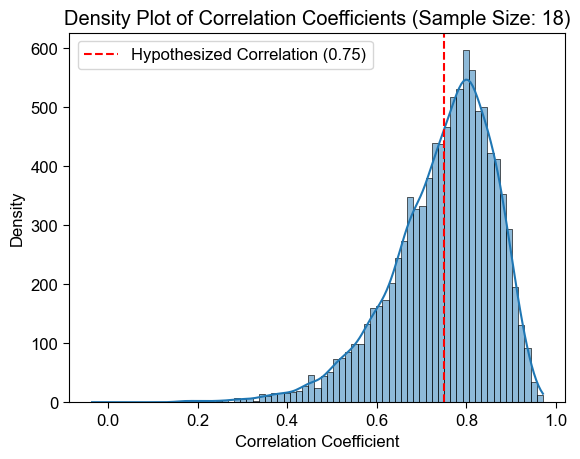

In [204]:
data = pd.read_csv('correl_pop.csv')

for i in range(B):
    # Draw a bootstrap sample with replacement
    bootstrap_sample = data.sample(n=18, replace=True)

    # Calculate correlation coefficient
    corr = bootstrap_sample['GPA'].corr(bootstrap_sample['SAT'])

    # Store correlation coefficient
    corr_coefs[i] = corr

# Calculate average correlation estimate
avg_corr_estimate = np.mean(corr_coefs)
print(f"Average Correlation Estimate (Sample Size {18}): {avg_corr_estimate}")

# Plot the density plot for each sample size
sns.histplot(corr_coefs, kde=True)
plt.title(f'Density Plot of Correlation Coefficients (Sample Size: {18})')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.show()

# Read the data
data = pd.read_csv('correl_pop.csv')

# Initialize array to store correlation coefficients
corr_coefs = np.zeros(B)

# Bootstrap procedure
for i in range(B):
    # Draw a bootstrap sample with replacement
    bootstrap_sample = data.sample(n=18, replace=True)

    # Calculate correlation coefficient
    corr = bootstrap_sample['GPA'].corr(bootstrap_sample['SAT'])

    # Store correlation coefficient
    corr_coefs[i] = corr

# Calculate proportion of correlation coefficients >= 0.75
p_value = np.mean(corr_coefs >= 0.75)

print(f"P-value: {p_value}")

# Plot the density plot for each sample size
sns.histplot(corr_coefs, kde=True)
plt.axvline(x=0.75, color='r', linestyle='--', label='Hypothesized Correlation (0.75)')
plt.title(f'Density Plot of Correlation Coefficients (Sample Size: {18})')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.legend()
plt.show()

95% Confidence Interval for Correlation Coefficient: [0.50337383 0.91821914]


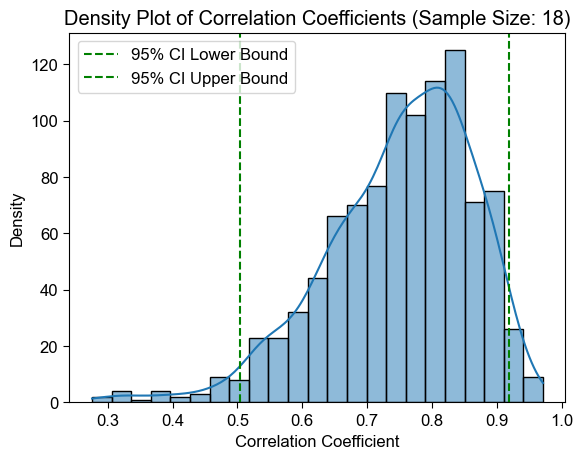

In [205]:
# Read the data
data = pd.read_csv('correl_pop.csv')

# Set the number of bootstrap samples
B = 1000  # Choose an appropriate number of bootstrap samples

# Initialize array to store correlation coefficients
corr_coefs = np.zeros(B)

# Bootstrap procedure
for i in range(B):
    # Draw a bootstrap sample with replacement
    bootstrap_sample = data.sample(n=18, replace=True)

    # Calculate correlation coefficient
    corr = bootstrap_sample['GPA'].corr(bootstrap_sample['SAT'])

    # Store correlation coefficient
    corr_coefs[i] = corr

# Calculate 95% confidence interval
confidence_interval = np.percentile(corr_coefs, [2.5, 97.5])

print(f"95% Confidence Interval for Correlation Coefficient: {confidence_interval}")

# Plot the density plot for each sample size
sns.histplot(corr_coefs, kde=True)
plt.axvline(x=confidence_interval[0], color='g', linestyle='--', label='95% CI Lower Bound')
plt.axvline(x=confidence_interval[1], color='g', linestyle='--', label='95% CI Upper Bound')
plt.title(f'Density Plot of Correlation Coefficients (Sample Size: {18})')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Density')
plt.legend()
plt.show()


# Question 7

In [206]:
df = 3  # degrees of freedom for t-distribution
mu = 0  # mean of the t-distribution
sample_sizes = [5, 10, 100, 500, 1000, 10000]  # different sample sizes to test
num_samples = 10000  # number of samples to draw for each sample size

def t_distribution(n):
    return np.random.standard_t(df, n)

In [207]:
sample_means = {}
sample_variances = {}
for n in sample_sizes:
    means = []
    variances = []
    for _ in range(num_samples):
        sample = t_distribution(n)
        means.append(np.mean(sample))
        variances.append(np.var(sample, ddof=1))  # Use ddof=1 for unbiased estimate
    sample_means[n] = means
    # Correct variance calculation: Variance of the means, not means of variances
    sample_variances[n] = np.var(means, ddof=1)

print("Sample Means:")
for n, means in sample_means.items():
    print(f"Sample Size: {n}, Mean: {np.mean(means)}")

print("\nSample Variances:")
for n, variances in sample_variances.items():
    print(f"Sample Size: {n}, Variance: {variances}")  

Sample Means:
Sample Size: 5, Mean: 0.002043053774456321
Sample Size: 10, Mean: -0.0028130930704500317
Sample Size: 100, Mean: -0.0013544675595844728
Sample Size: 500, Mean: -0.00038463852764313657
Sample Size: 1000, Mean: -0.0005445670435586692
Sample Size: 10000, Mean: 0.00037379366708626663

Sample Variances:
Sample Size: 5, Variance: 0.5679449375374929
Sample Size: 10, Variance: 0.2886333859674189
Sample Size: 100, Variance: 0.02909248379719785
Sample Size: 500, Variance: 0.005897128250776306
Sample Size: 1000, Variance: 0.0030315404500622332
Sample Size: 10000, Variance: 0.0002986244657808438


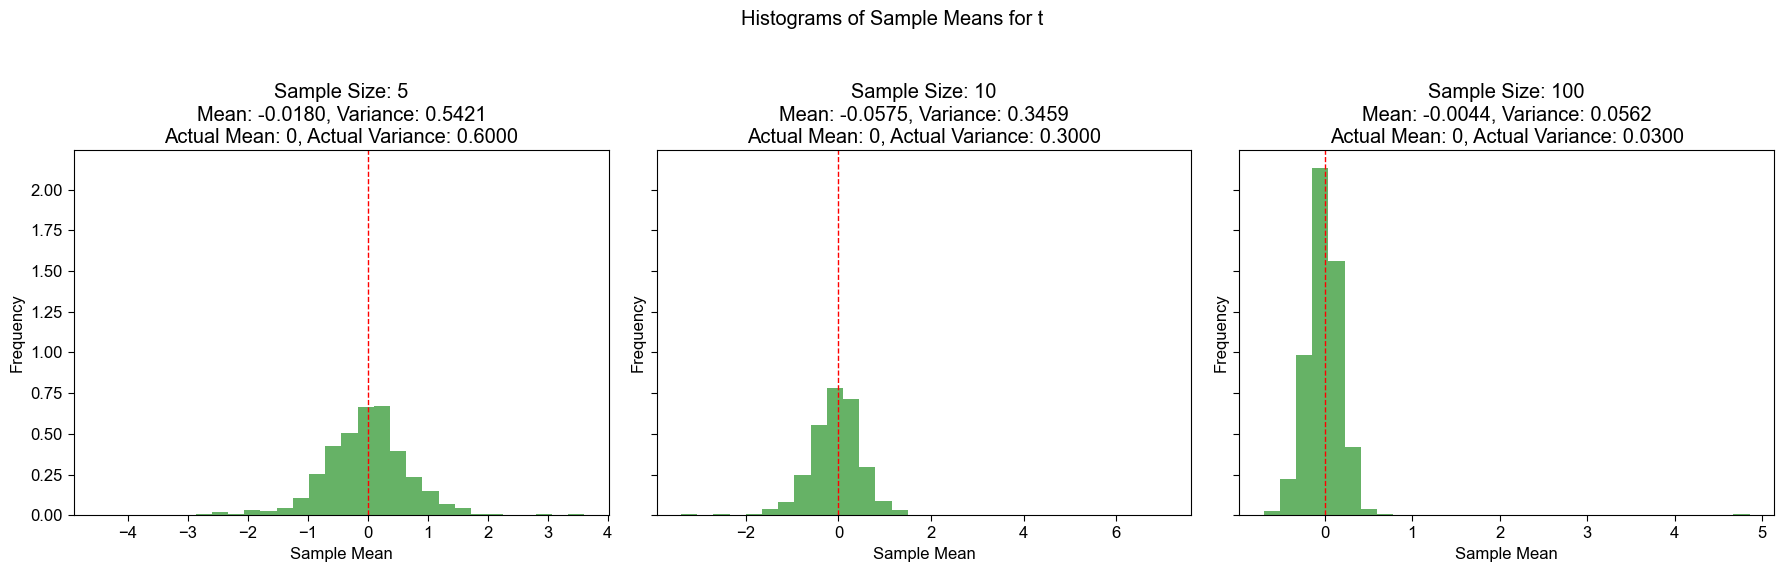

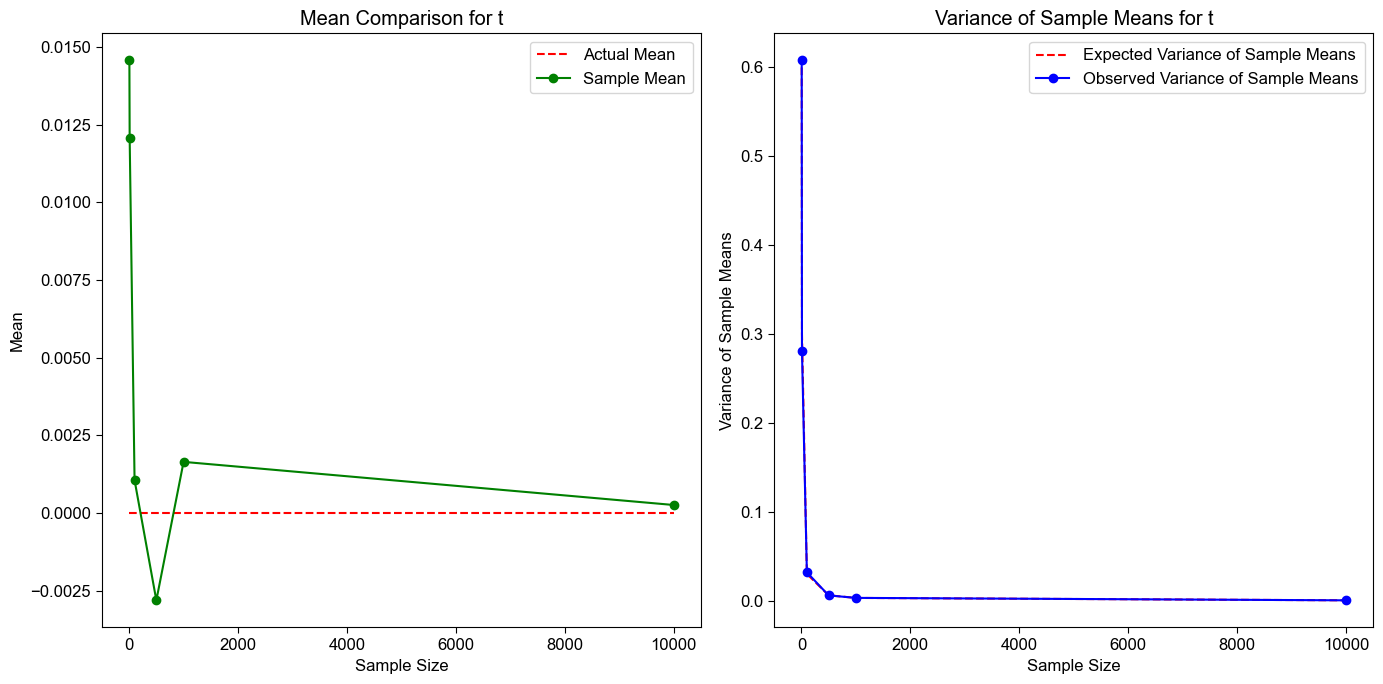

In [211]:
def t_distribution(n):
    return np.random.standard_t(3, n)


# Function to generate sample stats
def generate_sample_stats(distribution_func, sample_sizes, num_samples):
    sample_means = {}
    sample_variances = {}
    for n in sample_sizes:
        means = []
        variances = []
        for _ in range(num_samples):
            sample = distribution_func(n)
            means.append(np.mean(sample))
            variances.append(np.var(sample, ddof=1))  # Use ddof=1 for unbiased estimate
        sample_means[n] = means
        # Correct variance calculation: Variance of the means, not means of variances
        sample_variances[n] = np.var(means, ddof=1)
    return sample_means, sample_variances

# Main distribution parameters
main_distribution = {
    "t": {"mean": 0, "variance": 3}
}

# Sample sizes and number of samples
sample_sizes = [5,10,100,500,1000,10000]
num_samples = 1000

# Generate sample means and variances for each distribution
for distribution_name, params in main_distribution.items():
    distribution_func = globals()[f"{distribution_name.lower()}_distribution"]
    actual_mean = params["mean"]
    actual_variance = params["variance"]

    sample_means, sample_variances = generate_sample_stats(distribution_func, sample_sizes, num_samples)

    # Plotting histograms for the means of sample sizes 10, 100, 1000
    fig, axs = plt.subplots(1, 3, figsize=(18, 6), sharey=True)
    fig.suptitle(f'Histograms of Sample Means for {distribution_name}')

    for ax, (n, means) in zip(axs, sample_means.items()):
        ax.hist(means, bins=30, density=True, alpha=0.6, color='g')
        ax.axvline(actual_mean, color='r', linestyle='dashed', linewidth=1)
        ax.set_title(f'Sample Size: {n}\nMean: {np.mean(means):.4f}, Variance: {np.var(means, ddof=1):.4f}\nActual Mean: {actual_mean}, Actual Variance: {actual_variance / n:.4f}')
        ax.set_xlabel('Sample Mean')
        ax.set_ylabel('Frequency')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Step 2: Define a function to generate sample means and variances
def generate_sample_stats(distribution_func, sample_sizes, num_samples):
    sample_means = []
    sample_variances = []
    for n in sample_sizes:
        means = []
        variances = []
        for _ in range(num_samples):
            sample = distribution_func(n)
            means.append(np.mean(sample))
            variances.append(np.var(sample, ddof=1))  # Use ddof=1 for unbiased estimate
        sample_means.append(np.mean(means))
        # Correct variance calculation: Variance of the means, not means of variances
        sample_variances.append(np.var(means, ddof=1))
    return sample_means, sample_variances


# Define main distribution parameters
main_distribution = {
    "t": {"mean": 0, "variance": 3}
}

# Define sample sizes and number of samples
sample_sizes = [5,10,100,500,1000,10000]
num_samples = 1000

# Generate sample means and variances for each distribution, and plot the results
for distribution_name, params in main_distribution.items():
    distribution_func = globals()[f"{distribution_name.lower()}_distribution"]
    actual_mean = params["mean"]
    actual_variance = params["variance"]

    sample_means, sample_variances = generate_sample_stats(distribution_func, sample_sizes, num_samples)

    # Plotting Mean and Variance changes
    plt.figure(figsize=(14, 7))

    # Plot for Means
    plt.subplot(1, 2, 1)
    plt.plot(sample_sizes, [actual_mean] * len(sample_sizes), 'r--', label='Actual Mean')
    plt.plot(sample_sizes, sample_means, 'g-o', label='Sample Mean')
    plt.xlabel('Sample Size')
    plt.ylabel('Mean')
    plt.title(f'Mean Comparison for {distribution_name}')
    plt.legend()

    # Plot for Variance of Sample Means
    plt.subplot(1, 2, 2)
    expected_variance = [actual_variance / n for n in sample_sizes]  # Expected decrease as per CLT
    plt.plot(sample_sizes, expected_variance, 'r--', label='Expected Variance of Sample Means')
    plt.plot(sample_sizes, sample_variances, 'b-o', label='Observed Variance of Sample Means')
    plt.xlabel('Sample Size')
    plt.ylabel('Variance of Sample Means')
    plt.title(f'Variance of Sample Means for {distribution_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()
# Repeat the plotting process for other distributions as needed

As we can see, mean is going to 0 & variance is going to 0.

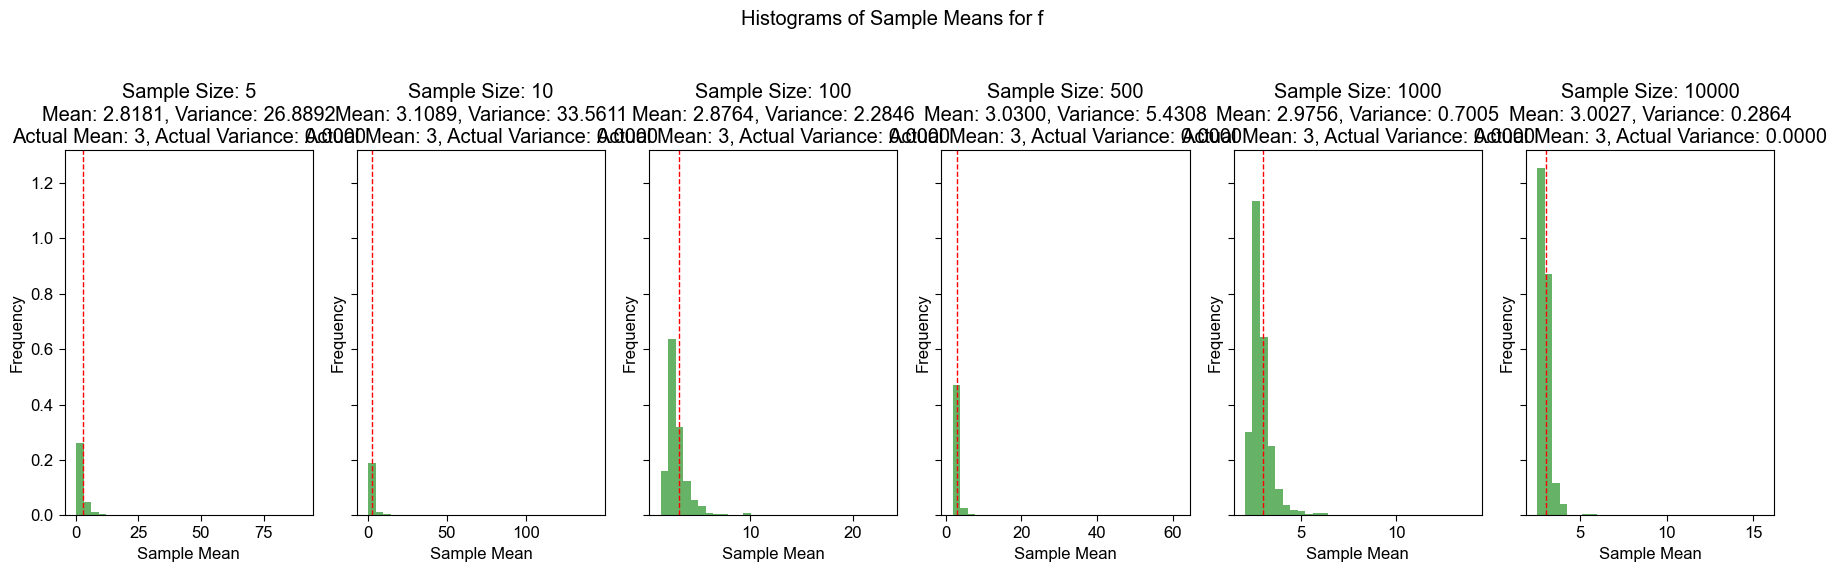

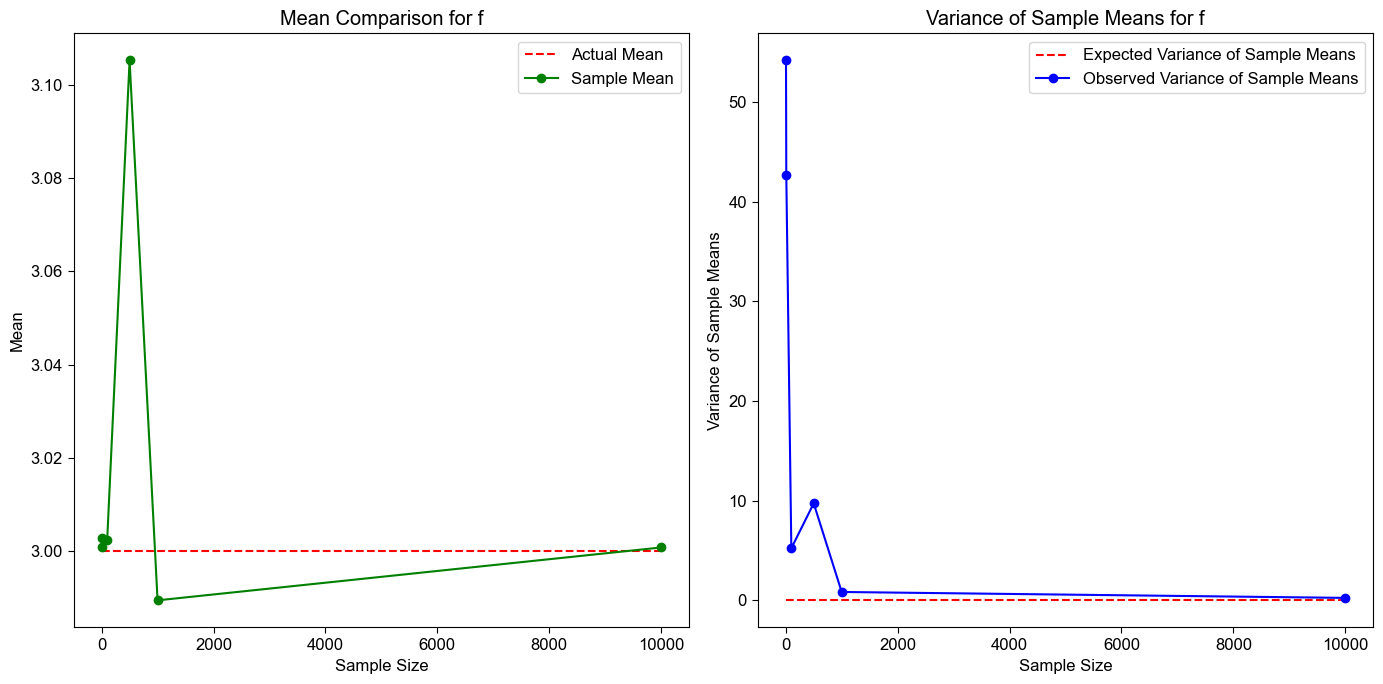

In [210]:
# Use f-distribution with df = 3
def f_distribution(n):
    return np.random.f(df, df, n)


def t_distribution(n):
    return np.random.standard_t(3, n)


# Function to generate sample stats
def generate_sample_stats(distribution_func, sample_sizes, num_samples):
    sample_means = {}
    sample_variances = {}
    for n in sample_sizes:
        means = []
        variances = []
        for _ in range(num_samples):
            sample = distribution_func(n)
            means.append(np.mean(sample))
            variances.append(np.var(sample, ddof=1))  # Use ddof=1 for unbiased estimate
        sample_means[n] = means
        # Correct variance calculation: Variance of the means, not means of variances
        sample_variances[n] = np.var(means, ddof=1)
    return sample_means, sample_variances

# Main distribution parameters
main_distribution = {
    "f": {"mean": 3, "variance": 0}
}

# Sample sizes and number of samples
sample_sizes = [5,10,100,500,1000,10000]
num_samples = 1000

# Generate sample means and variances for each distribution
for distribution_name, params in main_distribution.items():
    distribution_func = globals()[f"{distribution_name.lower()}_distribution"]
    actual_mean = params["mean"]
    actual_variance = params["variance"]

    sample_means, sample_variances = generate_sample_stats(distribution_func, sample_sizes, num_samples)

    # Plotting histograms for the means of sample sizes 10, 100, 1000
    fig, axs = plt.subplots(1, 6, figsize=(18, 6), sharey=True)
    fig.suptitle(f'Histograms of Sample Means for {distribution_name}')

    for ax, (n, means) in zip(axs, sample_means.items()):
        ax.hist(means, bins=30, density=True, alpha=0.6, color='g')
        ax.axvline(actual_mean, color='r', linestyle='dashed', linewidth=1)
        ax.set_title(f'Sample Size: {n}\nMean: {np.mean(means):.4f}, Variance: {np.var(means, ddof=1):.4f}\nActual Mean: {actual_mean}, Actual Variance: {actual_variance / n:.4f}')
        ax.set_xlabel('Sample Mean')
        ax.set_ylabel('Frequency')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Step 2: Define a function to generate sample means and variances
def generate_sample_stats(distribution_func, sample_sizes, num_samples):
    sample_means = []
    sample_variances = []
    for n in sample_sizes:
        means = []
        variances = []
        for _ in range(num_samples):
            sample = distribution_func(n)
            means.append(np.mean(sample))
            variances.append(np.var(sample, ddof=1))  # Use ddof=1 for unbiased estimate
        sample_means.append(np.mean(means))
        # Correct variance calculation: Variance of the means, not means of variances
        sample_variances.append(np.var(means, ddof=1))
    return sample_means, sample_variances


# Define main distribution parameters
main_distribution = {
    "f": {"mean": 3, "variance": 0}
}

# Define sample sizes and number of samples
sample_sizes = [5,10,100,500,1000,10000]
num_samples = 1000

# Generate sample means and variances for each distribution, and plot the results
for distribution_name, params in main_distribution.items():
    distribution_func = globals()[f"{distribution_name.lower()}_distribution"]
    actual_mean = params["mean"]
    actual_variance = params["variance"]

    sample_means, sample_variances = generate_sample_stats(distribution_func, sample_sizes, num_samples)

    # Plotting Mean and Variance changes
    plt.figure(figsize=(14, 7))

    # Plot for Means
    plt.subplot(1, 2, 1)
    plt.plot(sample_sizes, [actual_mean] * len(sample_sizes), 'r--', label='Actual Mean')
    plt.plot(sample_sizes, sample_means, 'g-o', label='Sample Mean')
    plt.xlabel('Sample Size')
    plt.ylabel('Mean')
    plt.title(f'Mean Comparison for {distribution_name}')
    plt.legend()

    # Plot for Variance of Sample Means
    plt.subplot(1, 2, 2)
    expected_variance = [actual_variance / n for n in sample_sizes]  # Expected decrease as per CLT
    plt.plot(sample_sizes, expected_variance, 'r--', label='Expected Variance of Sample Means')
    plt.plot(sample_sizes, sample_variances, 'b-o', label='Observed Variance of Sample Means')
    plt.xlabel('Sample Size')
    plt.ylabel('Variance of Sample Means')
    plt.title(f'Variance of Sample Means for {distribution_name}')
    plt.legend()

    plt.tight_layout()
    plt.show()
# Repeat the plotting process for other distributions as needed


Again, as in the t-distribution, in the f-distribution, as the sample size increased, the sample_mean converged to the true_mean and the variance went towards 0.

When we increase the number of samples in a population whose distribution function we do not know, the distribution in this population converges to the normal distribution, this is called the Central Limit Theorem. 

The CLT allows us to estimate the population parameters in a population with unknown distribution, giving us a prediction.